# Generating plots for the paper

The code in this notebook generates Table 4, Figures 5 and 6 in our paper on [Provenance Graph Kernel](https://arxiv.org/abs/2010.10343). It is run automatically as part of the evaluation pipeline (`make plots`).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper")

## Loading scoring and timing data

In [2]:
def load_scoring(dataset_id) -> pd.DataFrame:
    outputs_folder = Path("outputs") / dataset_id
    output_filepath = outputs_folder / "scoring.pickled"
    
    results = pd.read_pickle(output_filepath)
    
    return results

In [3]:
# Identifiers for the six datasets
dataset_ids = ["MIMIC-PXC7", "CM-Buildings", "CM-Routes", "CM-RouteSets", "PG-T", "PG-D"]
dataset_names = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]

In [4]:
# The following graph kernels are in the "slow" group
slow_GKs = {"GK-GSamp", "GK-NSPD", "GK-NH", "GK-SPath"}

def name_group(method: str) -> str:
    if method in slow_GKs:
        return "GK-slow"
    elif method.startswith("GK-"):
        # all other graph kernels are in the "fast" group
        return "GK-fast"
    elif method.startswith("PNA-"):
        # Provenance Network Analytics method
        return "PNA"
    elif method.startswith("FG-"):
        # provenance kernels using generic PROV types
        return "PK-G"
    elif method.startswith("FA-"):
        # provenance kernels using generic PROV types and application types
        return "PK-A"
    else:
        return "AppData"

def best_performers(results: pd.DataFrame, scoring="accuracy"):
    # Give them a group name for plotting
    results = results.copy()
    # add a "group_name" column to the table
    results["group_name"] = results.method.map(name_group)

    best_methods = {
        # for each group, find the method that has the best mean scoring (default to accuracy)
        results[results.group_name == group_name].groupby("method")[scoring].mean().idxmax()
        for group_name in ["PK-G", "PK-A", "PNA", "GK-slow", "GK-fast"]
    }

    # return a filtered table with only the best methods identified above
    return results[results.method.isin(best_methods)]

### Loading scoring of the best methods

In [5]:
scorings = pd.DataFrame()

for dataset_id, dataset_name in zip(dataset_ids, dataset_names):
    # load the scoring data for this classification task
    df = load_scoring(dataset_id)
    df["dataset"] = dataset_name
    # only keep the scoring data of the best-performing methods in this task
    scorings = scorings.append(
        best_performers(df),
        ignore_index=True
    )

## Comparing timings of the best methods in each classificaition task

In [6]:
summary = scorings.groupby(["dataset", "group_name", "method"]).mean()
summary.head()

accuracy        f1    recall  precision       time
dataset group_name method                                                     
CM-B    GK-fast    GK-HC-5  0.864762  0.864762  0.864762   0.864762   0.616397
        GK-slow    GK-NSPD  0.896861  0.896861  0.896861   0.896861   7.971444
        PK-A       FA-1     0.869148  0.869148  0.869148   0.869148   0.359296
        PK-G       FG-3     0.868929  0.868929  0.868929   0.868929   0.408910
        PNA        PNA-RF   0.895254  0.895254  0.895254   0.895254  55.191348

### Finding the time cost of the best PK method (between PK-G and PK-A)

In [7]:
best_pk_accuracy = dict()  # best accuracy between PK-G and PK-A for a classification task
pk_time = dict()  # and its corresponding time cost

for row in summary.itertuples():
    dataset, group_name, method = row.Index

    if group_name in {"PK-G", "PK-A"}:
        to_be_updated = False
        try:
            if best_pk_accuracy[dataset] < row.accuracy:
                to_be_updated = True
        except KeyError:
            to_be_updated = True

        if to_be_updated:
            best_pk_accuracy[dataset] = row.accuracy
            pk_time[dataset] = row.time

### Calculating the relative time for all methods in each classification task

In [8]:
data = []

for row in summary.itertuples():
    dataset, group_name, method = row.Index
    relative_time = row.time / pk_time[dataset]
    data.append((dataset, group_name, method, row.accuracy, relative_time))

rel_time_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Accuracy", "Relative Time"])

In [9]:
# defining short names for methods to save space
method_short_names = {
    "FG-0": "G0",
    "FG-1": "G1",
    "FG-2": "G2",
    "FG-3": "G3",
    "FG-4": "G4",
    "FG-5": "G5",
    "FA-0": "A0",
    "FA-1": "A1",
    "FA-2": "A2",
    "FA-3": "A3",
    "FA-4": "A4",
    "FA-5": "A5",
    'PNA-DTree': "DT",
    'PNA-RF': "RF",
    'PNA-K-NB': "K-NB",
    'PNA-NBayes': "NB",
    'PNA-NN': "NN",
    'PNA-SVM': "SVM",
    'GK-SPath': "SP",
    'GK-EHist': "EH",
    'GK-VHist': "VH",
    'GK-GSamp': "GS",
    "GK-WL-1": "WL1",
    "GK-WL-2": "WL2",
    "GK-WL-3": "WL3",
    "GK-WL-4": "WL4",
    "GK-WL-5": "WL5",
    "GK-NH": "NH",
    "GK-HC-5": "HC5",
    "GK-NSPD": "NSPD",
}

### Table 4
Within each dataset, we report the time cost of the best-performing method (shown in parentheses) from each comparison group relative to the time taken by the best-performing PK method (whose time cost shown as 1.0).

In [10]:
rel_time_df["time_method"] = rel_time_df.apply(
    lambda row: "%.1f (%s)" % (row[4], method_short_names[row[2]]),
    axis=1
)

In [11]:
rel_time_df.pivot(index="Dataset", columns="Group", values="time_method").reindex(dataset_names)[
    ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
]

Group,PK-G,PK-A,GK-fast,GK-slow,PNA
Dataset,,,,,
MIMIC,1.0 (G5),1.0 (A3),1.2 (WL5),66.7 (GS),222.2 (SVM)
CM-B,1.1 (G3),1.0 (A1),1.7 (HC5),22.2 (NSPD),153.6 (RF)
CM-R,0.9 (G0),1.0 (A0),1.6 (WL5),57.6 (NH),242.5 (DT)
CM-RS,1.0 (G3),0.9 (A2),1.4 (WL5),72.9 (NH),152.3 (DT)
PG-T,1.0 (G5),1.0 (A3),0.7 (WL5),21.6 (NH),120.7 (DT)
PG-D,1.5 (G5),1.0 (A2),0.8 (WL5),21.9 (NH),212.6 (SVM)


## Generating plots

In [12]:
# store the current colour palette
current_palette = sns.color_palette()

### Figure 5: The relative time costs of the best-performing methods reported in Table 4 plotted on the log scale

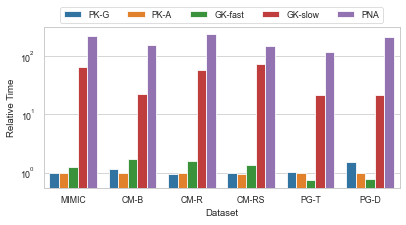

In [13]:
dataset_order = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]
selected_groups = ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
plot = sns.barplot(x="Dataset", y="Relative Time", hue="Group", order=dataset_order, hue_order=selected_groups, data=rel_time_df)
plot.set_yscale("log")
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plot.figure.set_size_inches(5.75, 3.25)
plt.tight_layout()

In [14]:
# saving the above plot
plot.figure.savefig("plots/best-performers-relative-timing.pdf")

### Figure 6: The mean classification accuracy of the best-performing provenance kernels, generic graph kernels, and PNA methods across the six classification tasks. The error bars show the 95-percent confidence intervals

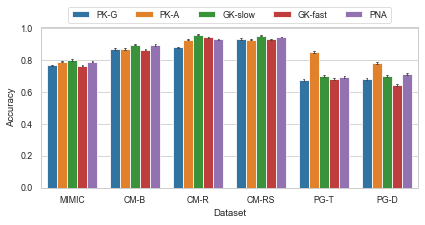

In [15]:
plt.figure()
selected_groups = ["PK-G", "PK-A", "GK-slow", "GK-fast", "PNA"]
df = scorings[scorings.group_name.isin(set(selected_groups))]
plot = sns.barplot(x="dataset", y="accuracy", hue="group_name",
                   hue_order=selected_groups, data=df, palette=current_palette,
                   errwidth=0.8, capsize=0.02)
plot.set(xlabel="Dataset", ylabel="Accuracy")
plot.figure.set_size_inches(6, 3.25)
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plt.tight_layout()

In [16]:
plot.figure.savefig("plots/accuracy-best-performers.pdf")